In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.model_selection import train_test_split
from pathlib import Path
import torchvision
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from PIL import Image
import random
import os,sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import helper

### Creation folder for data without blurring images

In [2]:
# Names of images in imputs and masks

data_images_names = os.listdir('./dataset_npy')
print(len(data_images_names))
data_masks_names = os.listdir('./masks_npy')
print(len(data_masks_names))

177
177


In [3]:
# Deletion names of blurring images from names

blurring_numbers = [str(i) for i in range(30,60)]

for y in blurring_numbers:
    data_images_names = [x for x in data_images_names if not y in x]
    
for y in blurring_numbers:
    data_masks_names = [x for x in data_masks_names if not y in x]
    
print(len(data_images_names))
print(len(data_masks_names))

87
87


In [4]:
data_images_names = sorted(data_images_names)
# print(data_images_names)

In [5]:
data_masks_names = sorted(data_masks_names)
# print(data_masks_names)

### Split data on train and validation 

In [6]:
train_images_names, val_images_names, train_masks_names, val_masks_names = \
                    train_test_split(data_images_names, data_masks_names, test_size=0.3, shuffle=True)

In [7]:
len(train_images_names)

60

In [8]:
# Creation folder for train and validation

if not os.path.exists('./train_val_dataset/train/images'):
    os.makedirs('./train_val_dataset/train/images')
    
if not os.path.exists('./train_val_dataset/train/masks'):
    os.makedirs('./train_val_dataset/train/masks')    

if not os.path.exists('./train_val_dataset/val/images'):
    os.makedirs('./train_val_dataset/val/images')
    
if not os.path.exists('./train_val_dataset/val/masks'):
    os.makedirs('./train_val_dataset/val/masks')

In [9]:
# Filling the folders for train and validation

for name in train_images_names:
    source = './dataset_npy/' + name
    destination = './train_val_dataset/train/images/' + name
    Path(source).rename(destination)

for name in train_masks_names:
    source = './masks_npy/' + name
    destination = './train_val_dataset/train/masks/' + name
    Path(source).rename(destination)

for name in val_images_names:
    source = './dataset_npy/' + name
    destination = './train_val_dataset/val/images/' + name
    Path(source).rename(destination)
    
for name in val_masks_names:
    source = './masks_npy/' + name
    destination = './train_val_dataset/val/masks/' + name
    Path(source).rename(destination)

### Dataloader

In [10]:
class MyDataset(Dataset):
    def __init__(self, images_folder, masks_folder,
                 img_transform=None, masks_transform=None):
        super(Dataset, self).__init__()
        
        self.images_folder = images_folder
        self.masks_folder = masks_folder

        self.images_names = np.sort(os.listdir(images_folder))
        self.masks_names = np.sort(os.listdir(masks_folder))
        
        self.img_transform = img_transform
        self.masks_transform = masks_transform

    def __len__(self):
        return len(self.images_names)
    
    def __getitem__(self, idx):
        item_image = np.load(os.path.join(self.images_folder,
                                            self.images_names[idx]))
        item_mask = np.load(os.path.join(self.masks_folder,
                                              self.masks_names[idx]))
        
        SEED = np.random.randint(123456789)
        if self.img_transform is not None:
            random.seed(SEED)
            item_image = self.img_transform(item_image)
        if self.masks_transform is not None:  
            random.seed(SEED)
            item_mask = self.masks_transform(item_mask)

        return item_image, item_mask

In [11]:
trans = transforms.Compose([
    transforms.ToTensor(),
])
train_set = MyDataset(images_folder = './train_val_dataset/train/images', 
                      masks_folder = './train_val_dataset/train/masks',
                      img_transform = trans, masks_transform = trans)
val_set = MyDataset(images_folder = './train_val_dataset/val/images', 
                      masks_folder = './train_val_dataset/val/masks',
                      img_transform = trans, masks_transform = trans)

In [12]:
# train_set.masks_names = train_set.masks_names[train_set.masks_names != '.DS_Store']

In [13]:
image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size_train = 8
batch_size_val = 8

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size_train, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size_val, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 60, 'val': 27}

torch.Size([8, 3, 400, 400]) torch.Size([8, 3, 400, 400])
0.0 1.0 0.8730797 0.33288422
0.0 1.0 0.042098437 0.20081323


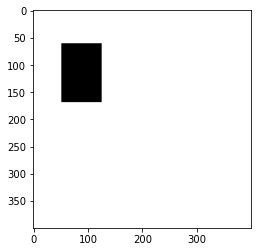

In [14]:
import torchvision.utils

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

plt.imshow(reverse_transform(inputs[3]))

In [15]:
from torchsummary import summary
import torch
import torch.nn as nn
import pytorch_unet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = pytorch_unet.UNet(3)
model = model.to(device)

summary(model, input_size=(3, 400, 400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 400, 400]           1,792
              ReLU-2         [-1, 64, 400, 400]               0
            Conv2d-3         [-1, 64, 400, 400]          36,928
              ReLU-4         [-1, 64, 400, 400]               0
         MaxPool2d-5         [-1, 64, 200, 200]               0
            Conv2d-6        [-1, 128, 200, 200]          73,856
              ReLU-7        [-1, 128, 200, 200]               0
            Conv2d-8        [-1, 128, 200, 200]         147,584
              ReLU-9        [-1, 128, 200, 200]               0
        MaxPool2d-10        [-1, 128, 100, 100]               0
           Conv2d-11        [-1, 256, 100, 100]         295,168
             ReLU-12        [-1, 256, 100, 100]               0
           Conv2d-13        [-1, 256, 100, 100]         590,080
             ReLU-14        [-1, 256, 1

In [16]:
from collections import defaultdict
import torch.nn.functional as F
from loss import dice_loss

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)    

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [17]:
import warnings
warnings.filterwarnings('ignore')

In [18]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 3

model = pytorch_unet.UNet(num_class).to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=70) 
# so many epochs because, e.g. on 40 epochs metrics can be ok, but predictions are not

cuda:0
Epoch 0/69
----------
LR 0.0001
train: bce: 0.679471, dice: 0.937313, loss: 0.808392
val: bce: 0.666483, dice: 0.931161, loss: 0.798822
saving best model
0m 4s
Epoch 1/69
----------
LR 0.0001
train: bce: 0.628496, dice: 0.935757, loss: 0.782126
val: bce: 0.411114, dice: 0.920779, loss: 0.665946
saving best model
0m 4s
Epoch 2/69
----------
LR 0.0001
train: bce: 0.186960, dice: 0.923838, loss: 0.555399
val: bce: 0.134755, dice: 0.921482, loss: 0.528118
saving best model
0m 4s
Epoch 3/69
----------
LR 0.0001
train: bce: 0.095002, dice: 0.894867, loss: 0.494935
val: bce: 0.082201, dice: 0.864249, loss: 0.473225
saving best model
0m 4s
Epoch 4/69
----------
LR 0.0001
train: bce: 0.078432, dice: 0.869510, loss: 0.473971
val: bce: 0.081824, dice: 0.855980, loss: 0.468902
saving best model
0m 4s
Epoch 5/69
----------
LR 0.0001
train: bce: 0.074076, dice: 0.857549, loss: 0.465813
val: bce: 0.082308, dice: 0.848561, loss: 0.465435
saving best model
0m 4s
Epoch 6/69
----------
LR 0.0001
t

train: bce: 0.001006, dice: 0.003170, loss: 0.002088
val: bce: 0.001071, dice: 0.002850, loss: 0.001961
saving best model
0m 4s
Epoch 53/69
----------
LR 1.0000000000000002e-06
train: bce: 0.001004, dice: 0.003168, loss: 0.002086
val: bce: 0.001069, dice: 0.002847, loss: 0.001958
saving best model
0m 4s
Epoch 54/69
----------
LR 1.0000000000000002e-06
train: bce: 0.001004, dice: 0.003169, loss: 0.002086
val: bce: 0.001064, dice: 0.002839, loss: 0.001951
saving best model
0m 4s
Epoch 55/69
----------
LR 1.0000000000000002e-06
train: bce: 0.000999, dice: 0.003166, loss: 0.002082
val: bce: 0.001066, dice: 0.002842, loss: 0.001954
0m 4s
Epoch 56/69
----------
LR 1.0000000000000002e-06
train: bce: 0.000998, dice: 0.003160, loss: 0.002079
val: bce: 0.001061, dice: 0.002835, loss: 0.001948
saving best model
0m 4s
Epoch 57/69
----------
LR 1.0000000000000002e-06
train: bce: 0.000998, dice: 0.003158, loss: 0.002078
val: bce: 0.001059, dice: 0.002833, loss: 0.001946
saving best model
0m 4s
Epoch

(3, 3, 400, 400)


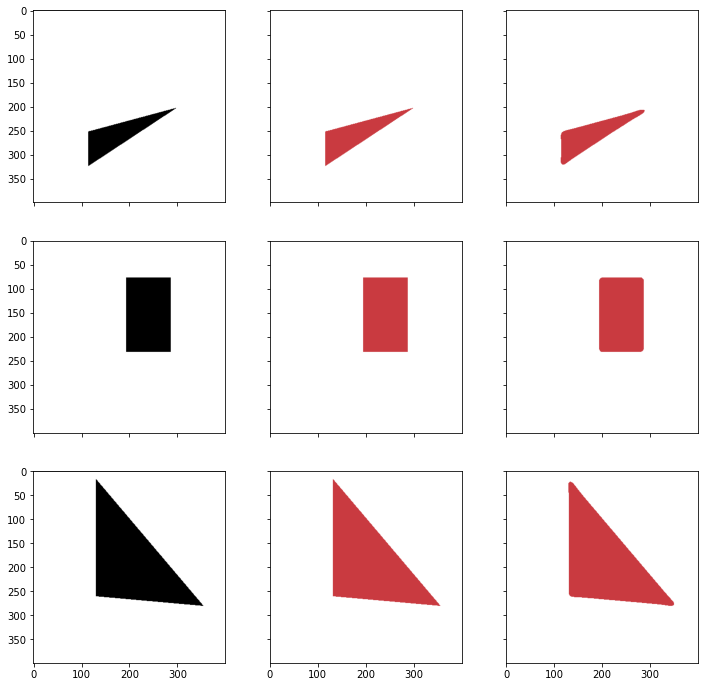

In [20]:
# prediction

import math

model.eval()   # Set model to evaluate mode

val_batch = torch.utils.data.DataLoader(val_set,
                                            batch_size=3,
                                            shuffle=True)
        
inputs, labels = next(iter(val_batch))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)

pred = pred.data.cpu().numpy()
print(pred.shape)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [helper.masks_to_colorimg(x) for x in pred]

helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])